In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [2]:
cat_nm = pd.read_csv('c_naive_metric.csv')
final_nm = pd.read_csv('final_naive_metric.csv')
naive_mw = pd.read_csv('naive_metric_wtc.csv')

cat_nm = cat_nm.drop('File Name', axis=1)
final_nm = final_nm.drop('File Name', axis=1)
naive_mw = naive_mw.drop('File Name', axis=1)

cat_nm.sample(5)

,Size,Fraction of Numeric attributes,Average Class Types,Classes target,target
13,8416,0.000000,5.318182,2,4
5,32561,0.428571,12.750000,2,4
8,45211,0.437500,4.888889,2,1
11,1000,0.150000,4.000000,2,1
14,1473,0.222222,3.142857,3,2


<Figure size 1440x1440 with 0 Axes>

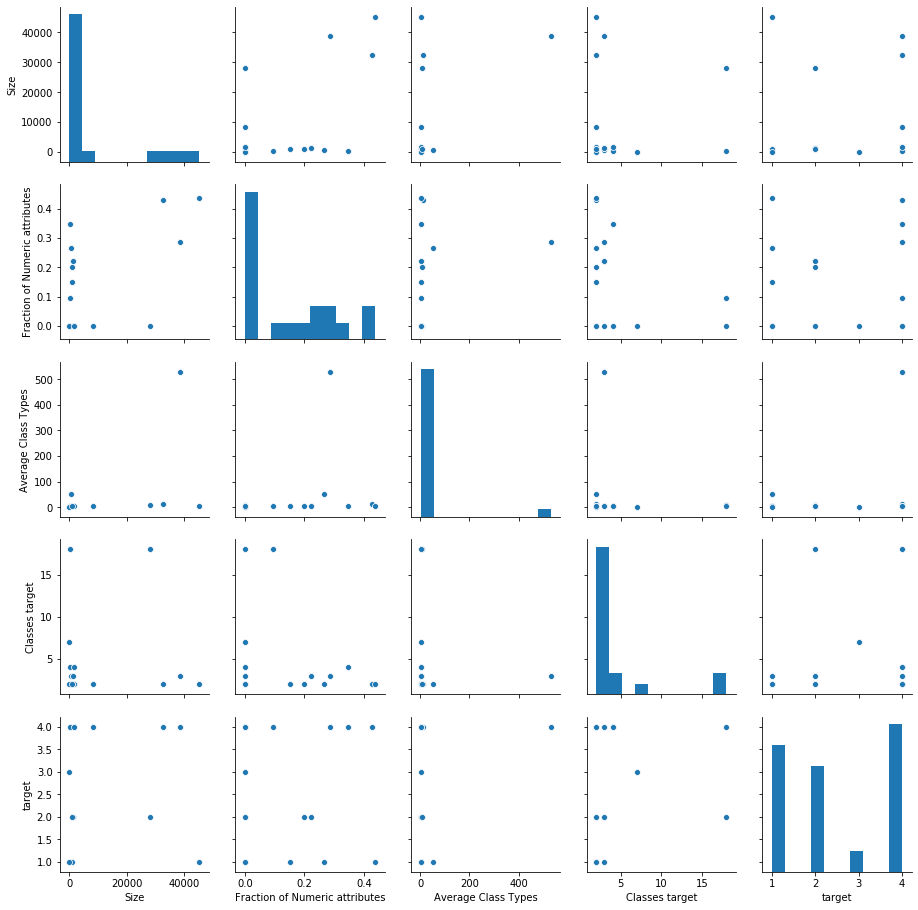

In [3]:
# EDA of c_naive_metric.csv
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.pairplot(cat_nm)
plt.show()

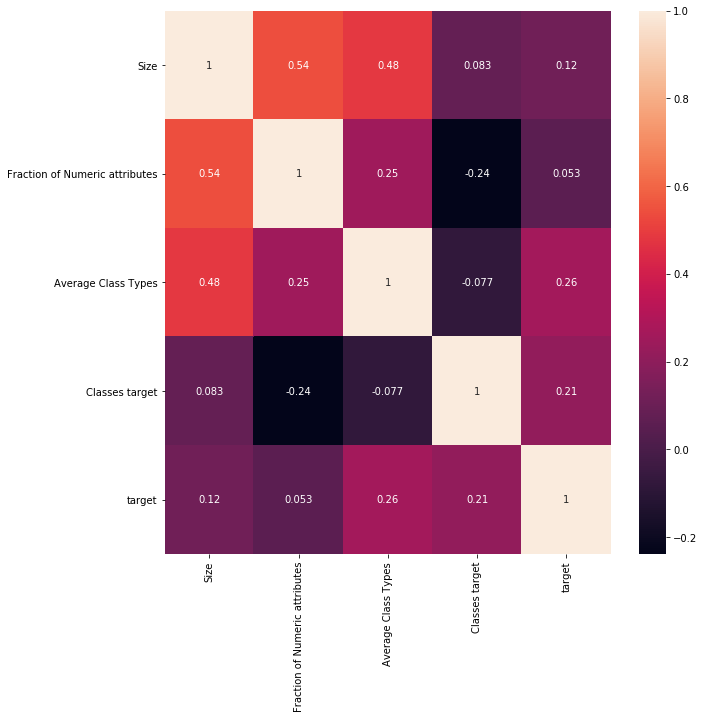

In [4]:
plt.figure(figsize=(10, 10))
sns.heatmap(cat_nm.corr(), annot=True)
plt.show()

## Information for c_naive_metric.csv

- The pair plots derive that none of the columns are dependent on each other and nor do they have correlation with each other

- The heatmap describes that there is very little dependency of target variable (max < 0.3) on the independent variables

<Figure size 1440x1440 with 0 Axes>

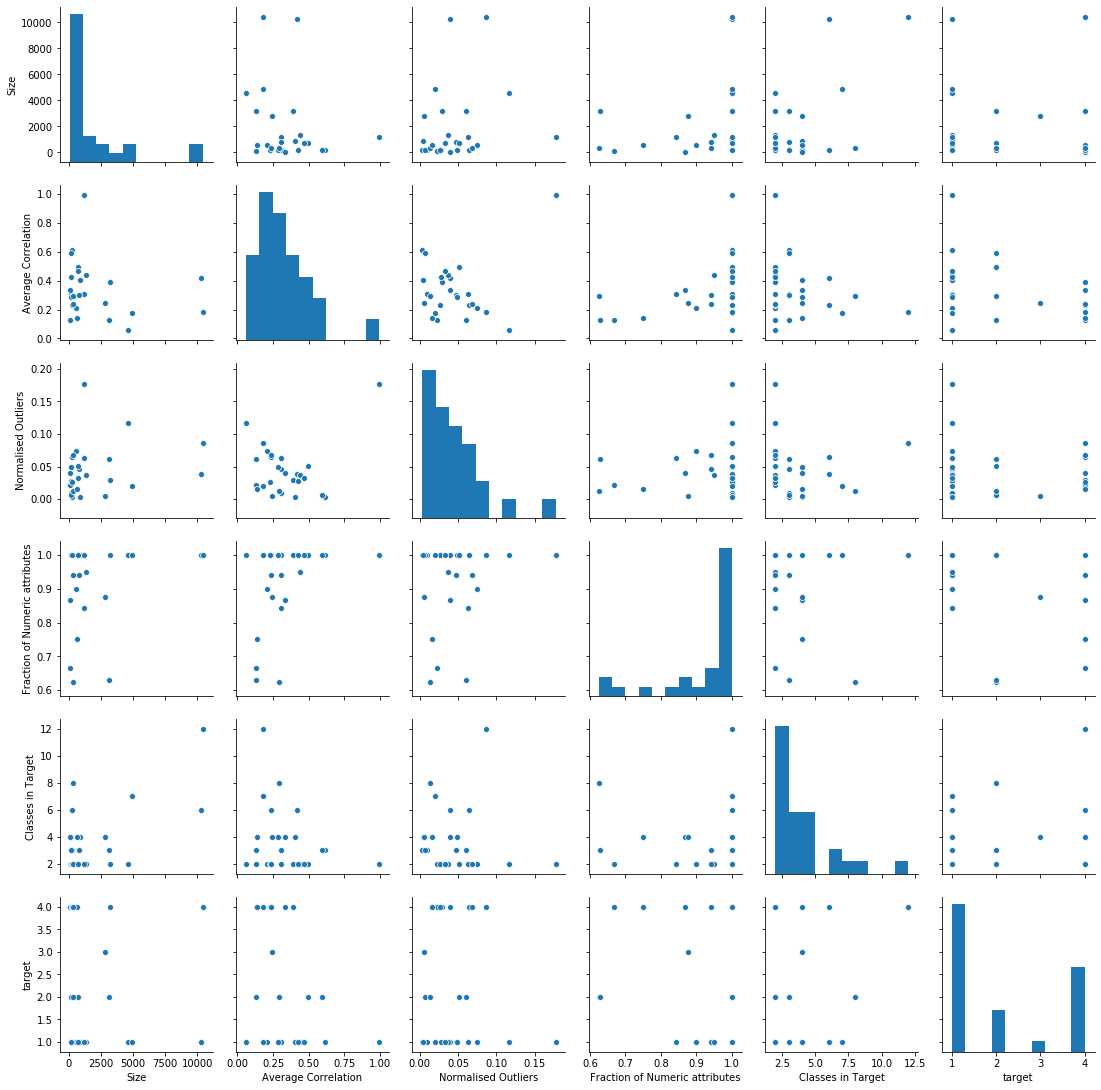

In [5]:
# EDA for 
plt.figure(figsize=(20, 20))
sns.pairplot(final_nm)
plt.show()

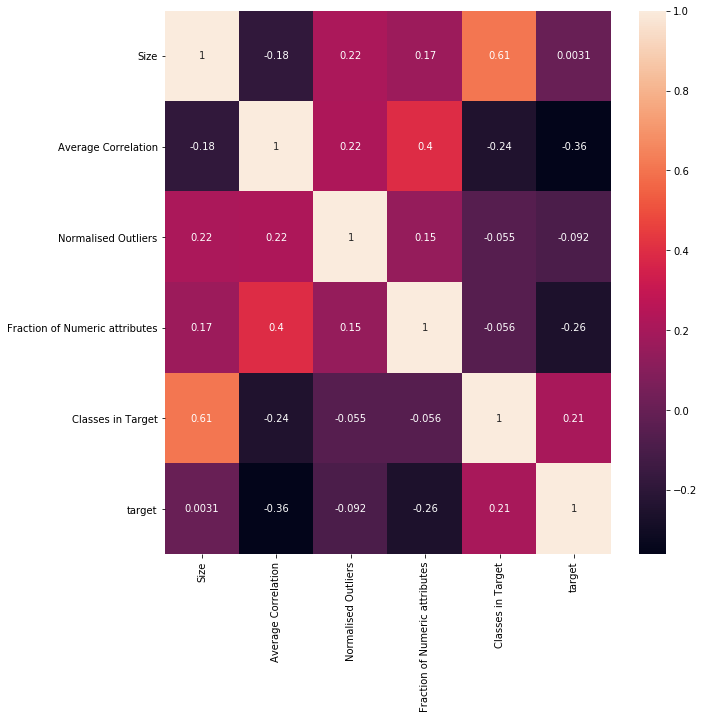

In [6]:
plt.figure(figsize=(10, 10))
sns.heatmap(final_nm.corr(), annot=True)
plt.show()

## Information for final naive metrics

- The information derived from the plots is same as that for c_naive_metric.csv
- Dependency of target column on independent columns is very low

<Figure size 1440x1440 with 0 Axes>

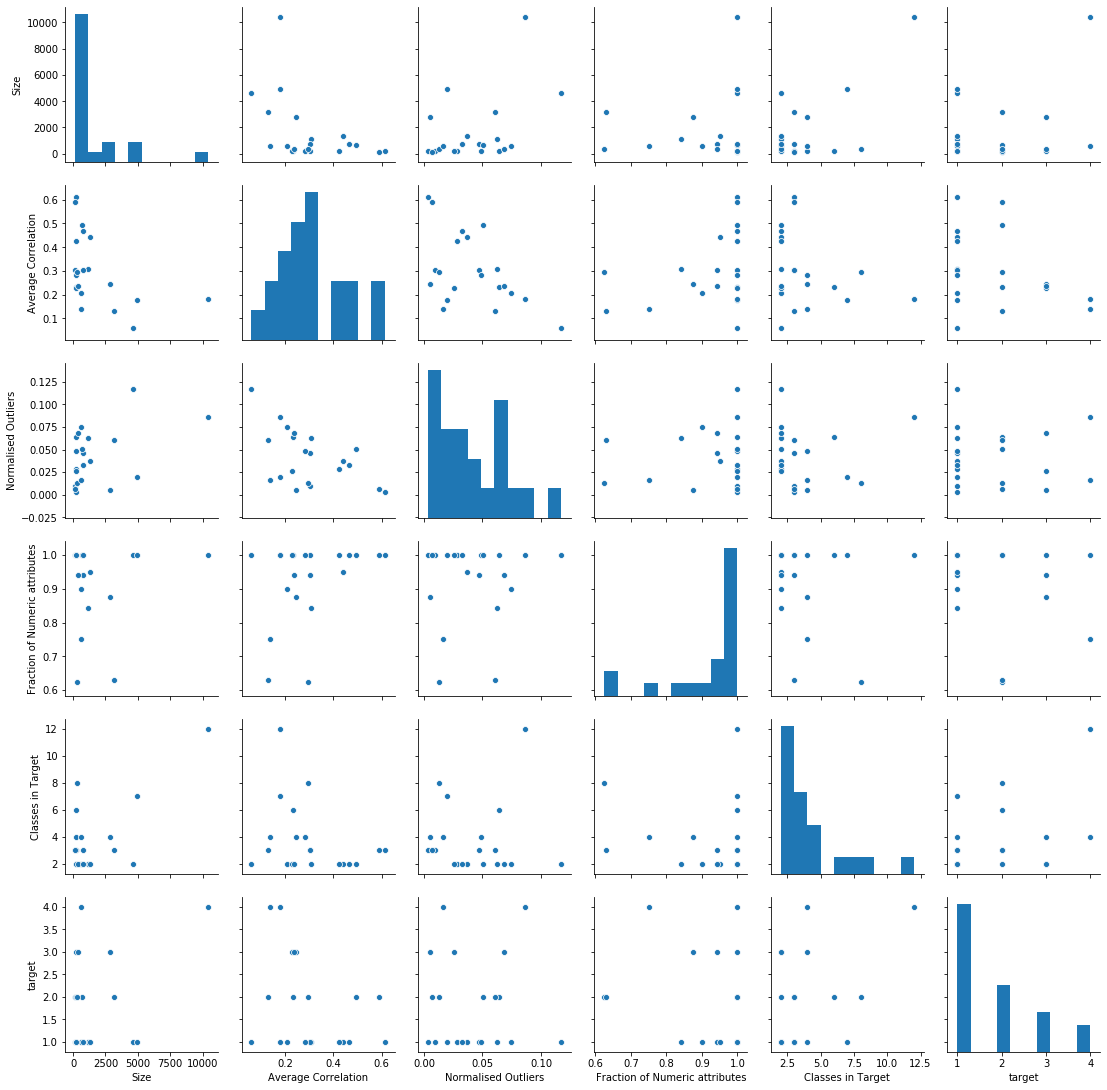

In [7]:
plt.figure(figsize=(20, 20))
sns.pairplot(naive_mw)
plt.show()

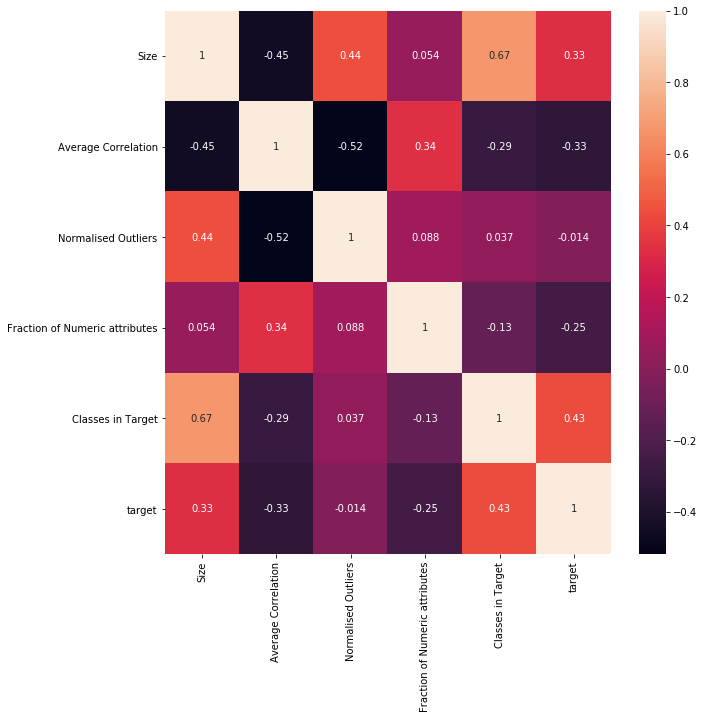

In [8]:
plt.figure(figsize=(10, 10))
sns.heatmap(naive_mw.corr(), annot=True)
plt.show()

## Information for naive_metric_wtc.csv

- Comparing the heatmap for naive_metric_wtc plots, we can see higher correlation between target and the independent columns
- This indicates that the accuracy and ROC AUC will be higher for the data provided in naive_metric_wtc.csv

## Applying hyperparameter optimization for KNN algorithm on given data

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from ray import tune
from ray.tune.suggest.hyperopt import HyperOptSearch
from hyperopt import hp
from hyperopt.pyll import scope

CV_FOLDS = 5

In [10]:
X = cat_nm.drop('target', axis=1)
y = cat_nm['target']

def objective(config):
    model = KNeighborsClassifier(**config)
    mean_validation_accuracy = cross_val_score(model,
                                              X, y, cv=CV_FOLDS).mean()
    tune.track.log(mean_accuracy=mean_validation_accuracy)

search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 1, 10, 1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'leaf_size': scope.int(hp.quniform('leaf_size', 5, 200, 10)),
    'p': scope.int(hp.quniform('p', 1, 20, 1)),
    'n_jobs': -1
}

hyperopt_search = HyperOptSearch(search_space, max_concurrent=4,
                                metric='mean_accuracy')

analysis = tune.run(objective, num_samples=100,
                   search_alg=hyperopt_search, verbose=1)

Trial name,status,loc,leaf_size,n_jobs,n_neighbors,p,weights,acc,iter,total time (s)
objective_f94db202,TERMINATED,,10,-1,5,7,uniform,0.483333,0,4.00271
objective_f95482da,TERMINATED,,20,-1,5,19,uniform,0.483333,0,4.37111
objective_f9597bdc,TERMINATED,,130,-1,6,13,uniform,0.533333,0,4.32237
objective_f95e319a,TERMINATED,,50,-1,7,4,uniform,0.483333,0,4.82859
objective_f964ef3a,TERMINATED,,130,-1,2,15,uniform,0.25,0,2.34609
objective_fdd3940e,TERMINATED,,100,-1,1,5,distance,0.633333,0,2.71921
objective_fe4b8202,TERMINATED,,20,-1,8,6,distance,0.583333,0,0.829717
objective_fe65443a,TERMINATED,,30,-1,2,1,distance,0.633333,0,2.80721
objective_fe8517e2,TERMINATED,,190,-1,6,3,distance,0.583333,0,2.55579
objective_000d791a,TERMINATED,,50,-1,8,5,distance,0.583333,0,0.849383


In [11]:
analysis_frame = analysis.dataframe()
analysis_frame.sort_values('mean_accuracy', ascending=False)

,mean_accuracy,trial_id,training_iteration,time_this_iter_s,done,timesteps_total,episodes_total,experiment_id,date,timestamp,...,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config/leaf_size,config/n_jobs,config/n_neighbors,config/p,config/weights,logdir
36,0.683333,1b893314,0,2.510287,False,NaN,NaN,ddfd92cdd7b0482aa84fc65f25c14c6e,2020-04-01_08-17-28,1585709248,...,2.510287,0,1,"37_leaf_size=60,n_jobs=-1,n_neighbors=5,p=9,we...",60,-1,5,9,distance,/home/adi/ray_results/objective/objective_37_l...
54,0.683333,2cac99f6,0,3.747638,False,NaN,NaN,e77312be4293445f999acf1ffaba5520,2020-04-01_08-17-58,1585709278,...,3.747638,0,1,"55_leaf_size=20,n_jobs=-1,n_neighbors=5,p=2,we...",20,-1,5,2,distance,/home/adi/ray_results/objective/objective_55_l...
34,0.683333,1830aed6,0,3.233052,False,NaN,NaN,8a9027cd2f6945da8fd00c30fd9843bb,2020-04-01_08-17-25,1585709245,...,3.233052,0,1,"35_leaf_size=150,n_jobs=-1,n_neighbors=5,p=19,...",150,-1,5,19,distance,/home/adi/ray_results/objective/objective_35_l...
86,0.683333,51801b04,0,3.400256,False,NaN,NaN,c43d0bfcc9274d8fab31aa54989bf562,2020-04-01_08-18-57,1585709337,...,3.400256,0,1,"87_leaf_size=80,n_jobs=-1,n_neighbors=5,p=15,w...",80,-1,5,15,distance,/home/adi/ray_results/objective/objective_87_l...
32,0.683333,162d0b0c,0,3.662735,False,NaN,NaN,087cc357df484600b2f6028ae2e1c3e7,2020-04-01_08-17-20,1585709240,...,3.662735,0,1,"33_leaf_size=70,n_jobs=-1,n_neighbors=5,p=9,we...",70,-1,5,9,distance,/home/adi/ray_results/objective/objective_33_l...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,0.366667,2669eeb8,0,3.554765,False,NaN,NaN,8cddbb7ae8eb4747b6dc7e37c69579b1,2020-04-01_08-17-44,1585709264,...,3.554765,0,1,"48_leaf_size=120,n_jobs=-1,n_neighbors=4,p=8,w...",120,-1,4,8,uniform,/home/adi/ray_results/objective/objective_48_l...
18,0.316667,075ee082,0,0.799705,False,NaN,NaN,ba19d49df4f24838b7ca6be913ad4feb,2020-04-01_08-16-54,1585709214,...,0.799705,0,1,"19_leaf_size=150,n_jobs=-1,n_neighbors=10,p=7,...",150,-1,10,7,uniform,/home/adi/ray_results/objective/objective_19_l...
10,0.250000,00e99f76,0,2.630202,False,NaN,NaN,cc8db7349ab041b1a283ad4ca8df2469,2020-04-01_08-16-43,1585709203,...,2.630202,0,1,"11_leaf_size=190,n_jobs=-1,n_neighbors=2,p=8,w...",190,-1,2,8,uniform,/home/adi/ray_results/objective/objective_11_l...
4,0.250000,f964ef3a,0,2.346090,False,NaN,NaN,4bd52010c4d14818856e12ac87b7157c,2020-04-01_08-16-35,1585709195,...,2.346090,0,1,"5_leaf_size=130,n_jobs=-1,n_neighbors=2,p=15,w...",130,-1,2,15,uniform,/home/adi/ray_results/objective/objective_5_le...


In [12]:
print('Best accuracy configs for c_naive_metric.csv is: ')
print(analysis.get_best_config(metric='mean_accuracy'))
cat_nm_configs = analysis.get_best_config(metric='mean_accuracy')

Best accuracy configs for c_naive_metric.csv is: 
{'leaf_size': 160, 'n_jobs': -1, 'n_neighbors': 5, 'p': 20, 'weights': 'distance'}


In [13]:
X = final_nm.drop('target', axis=1)
y = final_nm['target']

def objective(config):
    model = KNeighborsClassifier(**config)
    mean_validation_accuracy = cross_val_score(model,
                                              X, y, cv=CV_FOLDS).mean()
    tune.track.log(mean_accuracy=mean_validation_accuracy)

search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 1, 10, 1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'leaf_size': scope.int(hp.quniform('leaf_size', 5, 200, 10)),
    'p': scope.int(hp.quniform('p', 1, 20, 1)),
    'n_jobs': -1
}

hyperopt_search = HyperOptSearch(search_space, max_concurrent=4,
                                metric='mean_accuracy')

analysis = tune.run(objective, num_samples=100,
                   search_alg=hyperopt_search, verbose=1)

print('Best accuracy configs for final_naive_metric.csv is: ')
print(analysis.get_best_config(metric='mean_accuracy'))
final_nm_configs = analysis.get_best_config(metric='mean_accuracy')

Trial name,status,loc,leaf_size,n_jobs,n_neighbors,p,weights,acc,iter,total time (s)
objective_630e4058,TERMINATED,,80,-1,6,2,distance,0.413333,0,3.54397
objective_630f1a5a,TERMINATED,,150,-1,8,17,distance,0.446667,0,3.30522
objective_630fc2fc,TERMINATED,,170,-1,7,9,distance,0.446667,0,3.52111
objective_63106e8c,TERMINATED,,200,-1,7,16,distance,0.446667,0,2.82378
objective_63114762,TERMINATED,,190,-1,5,8,uniform,0.52,0,3.73596
objective_65d24a00,TERMINATED,,170,-1,3,10,distance,0.446667,0,4.24159
objective_66271166,TERMINATED,,120,-1,6,15,distance,0.446667,0,4.30864
objective_66507ac4,TERMINATED,,170,-1,9,11,distance,0.446667,0,4.10698
objective_67cdb236,TERMINATED,,30,-1,2,3,uniform,0.48,0,3.04805
objective_6b175816,TERMINATED,,40,-1,3,6,uniform,0.52,0,3.02317


Best accuracy configs for final_naive_metric.csv is: 
{'leaf_size': 110, 'n_jobs': -1, 'n_neighbors': 4, 'p': 19, 'weights': 'uniform'}


In [14]:
X = naive_mw.drop('target', axis=1)
y = naive_mw['target']

def objective(config):
    model = KNeighborsClassifier(**config)
    mean_validation_accuracy = cross_val_score(model,
                                              X, y, cv=CV_FOLDS).mean()
    tune.track.log(mean_accuracy=mean_validation_accuracy)

search_space = {
    'n_neighbors': scope.int(hp.quniform('n_neighbors', 1, 10, 1)),
    'weights': hp.choice('weights', ['uniform', 'distance']),
    'leaf_size': scope.int(hp.quniform('leaf_size', 5, 200, 10)),
    'p': scope.int(hp.quniform('p', 1, 20, 1)),
    'n_jobs': -1
}

hyperopt_search = HyperOptSearch(search_space, max_concurrent=4,
                                metric='mean_accuracy')

analysis = tune.run(objective, num_samples=100,
                   search_alg=hyperopt_search, verbose=1)

print('Best accuracy configs for naive_metric_wtc.csv is: ')
print(analysis.get_best_config(metric='mean_accuracy'))
naive_mw_configs = analysis.get_best_config(metric='mean_accuracy')

Trial name,status,loc,leaf_size,n_jobs,n_neighbors,p,weights,acc,iter,total time (s)
objective_d984acd6,TERMINATED,,100,-1,5,9,uniform,0.52,0,3.42554
objective_d986804c,TERMINATED,,70,-1,5,7,distance,0.42,0,3.62898
objective_d9872c72,TERMINATED,,120,-1,10,12,distance,0.42,0,0.925124
objective_d9880944,TERMINATED,,190,-1,5,1,uniform,0.52,0,3.23294
objective_d988b01a,TERMINATED,,40,-1,9,10,distance,0.42,0,0.89944
objective_dc77173a,TERMINATED,,180,-1,7,3,uniform,0.52,0,4.11408
objective_dccf369a,TERMINATED,,20,-1,4,6,distance,0.42,0,4.7598
objective_dd4463de,TERMINATED,,130,-1,2,9,uniform,0.42,0,4.37983
objective_de6b970a,TERMINATED,,90,-1,5,8,uniform,0.52,0,4.38542
objective_df35a1d0,TERMINATED,,120,-1,1,2,uniform,0.47,0,3.03472


Best accuracy configs for naive_metric_wtc.csv is: 
{'leaf_size': 100, 'n_jobs': -1, 'n_neighbors': 5, 'p': 9, 'weights': 'uniform'}


## Applying best configurations to the data and calculating it's accuracy

In [15]:
model_cat_nm = KNeighborsClassifier(**cat_nm_configs)
model_final_nm = KNeighborsClassifier(**final_nm_configs)
model_naive_mw = KNeighborsClassifier(**naive_mw_configs)

cross_validaition_score_1 = cross_val_score(model_cat_nm, cat_nm.drop('target', axis=1),
                                            cat_nm['target'], cv=CV_FOLDS).mean()
cross_validaition_score_2 = cross_val_score(model_final_nm, final_nm.drop('target', axis=1),
                                            final_nm['target'], cv=CV_FOLDS).mean()
cross_validaition_score_3 = cross_val_score(model_naive_mw, naive_mw.drop('target', axis=1),
                                            naive_mw['target'], cv=CV_FOLDS).mean()
print(f"CV mean accuracy for c_naive_metric.csv : {cross_validaition_score_1}")
print(f"CV mean accuracy for final_naive_metric.csv : {cross_validaition_score_2}")
print(f"CV mean accuracy for naive_metric_wtc.csv : {cross_validaition_score_3}")

CV mean accuracy for c_naive_metric.csv : 0.6833333333333333
CV mean accuracy for final_naive_metric.csv : 0.56
CV mean accuracy for naive_metric_wtc.csv : 0.52


## Applying custom ANN on all the data files and comparing accuracies

- Artificial neural network will be trained on all 3 files and their accuracies will be compared with KNN accuracies

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2

def get_model(input_shape):
    print(input_shape)
    model = Sequential([
        Dense(16, activation='relu', input_shape=(input_shape[1],), kernel_regularizer=l2(0.01)),
        Dropout(0.25),
        Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.25),
        Dense(5, activation='sigmoid')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [17]:
model_1 = get_model(cat_nm.drop('target', axis=1).shape)
model_2 = get_model(final_nm.drop('target', axis=1).shape)
model_3 = get_model(naive_mw.drop('target', axis=1).shape)

(19, 4)
(27, 5)
(21, 5)


In [18]:
from tensorflow.keras.utils import to_categorical

cat_nm_target = to_categorical(cat_nm['target'])
final_nm_target = to_categorical(final_nm['target'])
naive_mw_target = to_categorical(naive_mw['target'])

train_data_1, train_labels_1 = cat_nm.drop('target', axis=1)[:12], cat_nm_target[:12]
test_data_1, test_labels_1 = cat_nm.drop('target', axis=1)[12:], cat_nm_target[12:]

train_data_2, train_labels_2 = final_nm.drop('target', axis=1)[:20], final_nm_target[:20]
test_data_2, test_labels_2 = final_nm.drop('target', axis=1)[20:], final_nm_target[20:]

train_data_3, train_labels_3 = naive_mw.drop('target', axis=1)[:14], naive_mw_target[:14]
test_data_3, test_labels_3 = naive_mw.drop('target', axis=1)[14:], naive_mw_target[14:]

train_labels_1

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [19]:
history_1 = model_1.fit(train_data_1, train_labels_1,
                       epochs=50, validation_data=[test_data_1, test_labels_1], verbose=0)
history_2 = model_2.fit(train_data_2, train_labels_2,
                       epochs=50, validation_data=[test_data_2, test_labels_2], verbose=0)
history_3 = model_3.fit(train_data_3, train_labels_3,
                       epochs=50, validation_data=[test_data_3, test_labels_3], verbose=0)

In [20]:
val_acc_1 = history_1.history.get('val_acc')
val_acc_2 = history_2.history.get('val_acc')
val_acc_3 = history_3.history.get('val_acc')

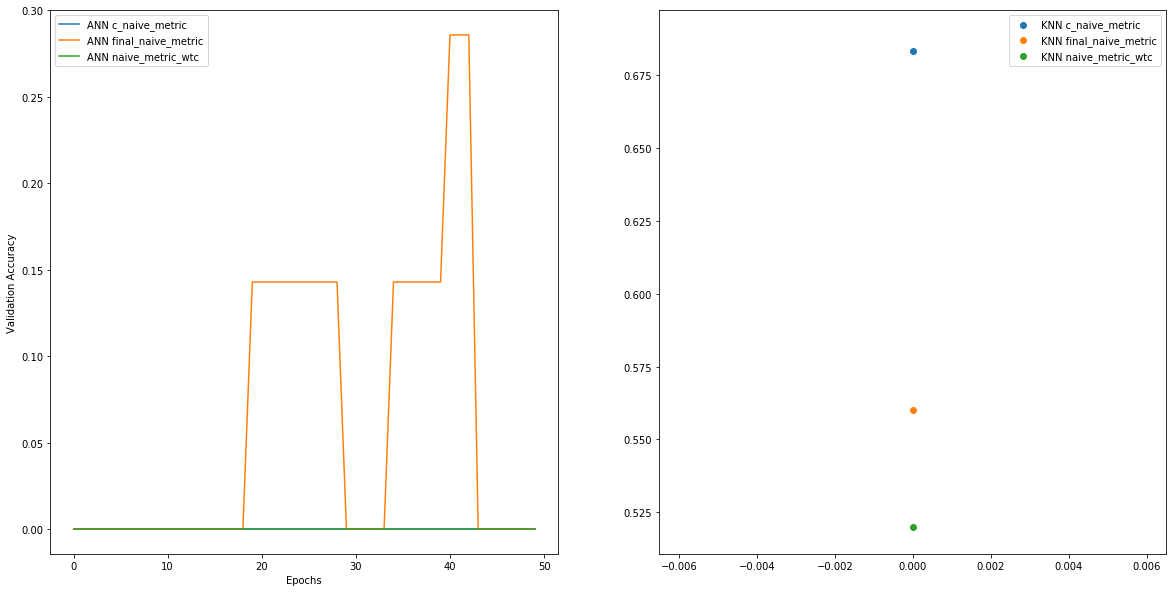

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(np.arange(50), val_acc_1, label='ANN c_naive_metric')
ax[0].plot(np.arange(50), val_acc_2, label='ANN final_naive_metric')
ax[0].plot(np.arange(50), val_acc_3, label='ANN naive_metric_wtc')
ax[1].scatter(x=np.arange(1), y=[cross_validaition_score_1], label='KNN c_naive_metric')
ax[1].scatter(x=np.arange(1), y=[cross_validaition_score_2], label='KNN final_naive_metric')
ax[1].scatter(x=np.arange(1), y=[cross_validaition_score_3], label='KNN naive_metric_wtc')
ax[0].legend()
ax[1].legend()
ax[0].set_ylabel('Validation Accuracy')
ax[0].set_xlabel('Epochs')
plt.show()